# Extrapolation tutorial
This tutorial illustrates recovery and extrapolation of the DRT from truncated data. For an introduction to the basic usage of the `DRT` class, please see "Simple ZARC tutorial."

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

# Load impedance data
For this example, we use data simulated from a circuit consisting of an ohmic resistance, a parallel resistor-inductor (RL) element, and two ZARC elements. The data is truncated such that the impedance responses of the high-frequency RL element and low-frequency ZARC element are not fully captured by the simulated experiment. Artifical noise from J.R. Macdonald's proportional error model was added. 

In [3]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [4]:
# load simulated data
circuit = 'trunc'
err_model = 'Macdonald'
noise_level = 0.25
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))
# load exact impedance over full frequency range
Zdf_full = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_noiseless_FullRange.csv'))
# make complex impedance array
Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values
# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


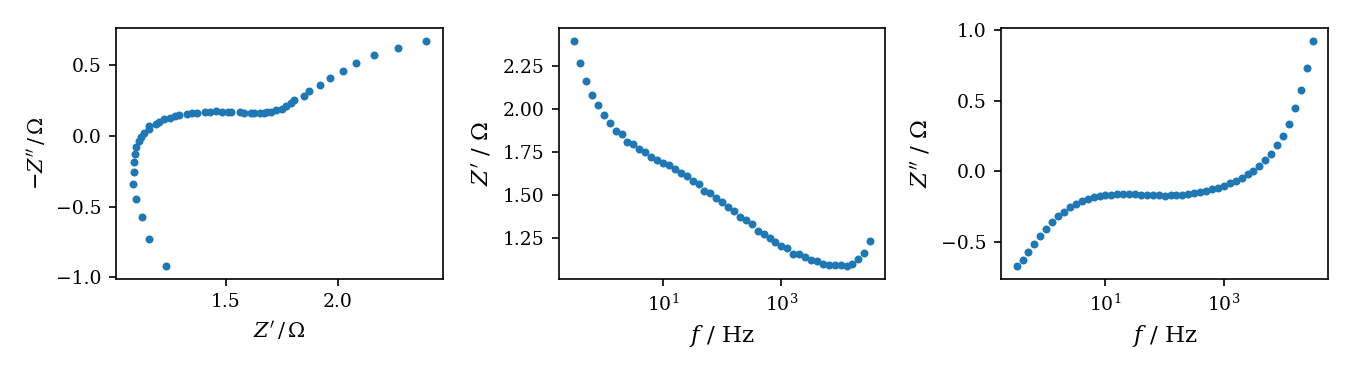

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
# plot the noisy impedance data
%matplotlib notebook
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'])
fig.tight_layout()

# Hyperparametric ridge fit
The data clearly contains truncated impedance features, suggesting that the underlying DRT must have density outside the bounds of the measured frequency range. Therefore, we use an expanded frequency range (or equivalently, time constant range) as the basis for the deconvolution.

In [19]:
# create DRT instance, specifying a wider frequency range to use as basis for the DRT
# (the basis_freq argument is converted to basis time constants)
dr_ridge = drt.DRT(basis_freq=np.logspace(6,-2,81))

# run hyperparametric ridge fit using the recommended hyperparameter values
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (including matrix construction): {:.3f} s'.format(elapsed))

# re-run with precalculated matrices
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (without matrix construction): {:.3f} s'.format(elapsed))

../bayes-drt\drt.py:1079: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


Hyperparametric ridge fit time (including matrix construction): 6.306 s
Hyperparametric ridge fit time (without matrix construction): 0.063 s


../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


Here, even though the basis time constants are not simply the inverted measurement frequencies, the inverted measurement frequencies are a subset of the basis time constants, such that the $\mathbf{A}$ matrices are still Toeplitz matrices. Thus, the matrix calculation is relatively fast.

In [8]:
def plot_drt_result(dr,Zdf,g_true,plot_ci=False):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = dr.predict(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='DRT fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # plot the true DRT
    axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
    # get the recovered DRT
    g_pred = dr.drt(g_true['tau'])
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = dr.drt(g_true['tau'],percentile=2.5)
        g_hi = dr.drt(g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Recovered',alpha=0.8)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \Omega$')

    for ax in axes.ravel():
        ax.legend()

    # add a vertical line in the DRT for the RL element
    axes[1,1].axvline(1e-6,lw=1,ls='--',ymax=ax.transLimits.transform((1,0))[1],zorder=-10)
    
    # mark measurement boundaries in DRT plot
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='k',lw=1)
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
        
    fig.tight_layout()

<IPython.core.display.Javascript object>


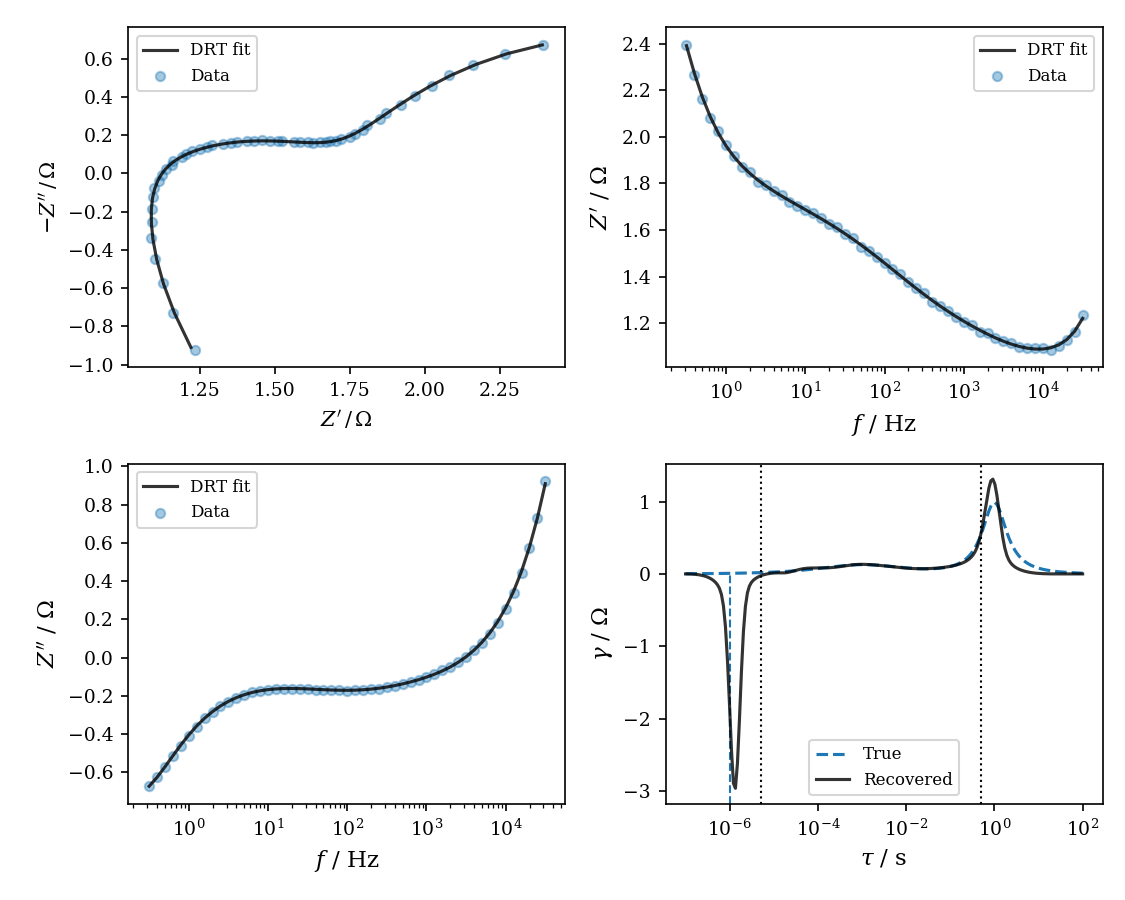

In [20]:
plot_drt_result(dr_ridge,Zdf,g_true)

The hyperparametric ridge fit identifies both truncated features fairly accurately, although their positions and shapes are somewhat imprecisely estimated. The blue dashed vertical line in the DRT plot indicates a Dirac delta function corresponding to the RL element. The black vertical dotted lines in the DRT plot indicate the time constants corresponding to the minimum and maximum measured frequencies.

The DRT can be used to extrapolate the impedance beyond the measured frequency range by supplying the `frequencies` argument to the `predict` method.

In [10]:
def plot_extrap(dr,Zdf,Zdf_full):
    fig,axes = plt.subplots(1,3,figsize=(9,2.75))
    
    # plot data
    gt.plot_full_eis(Zdf,axes=axes,alpha=0.4,s=20,label='Trunc. data',bode_cols=['Zreal','Zimag'])
    # plot true impedance over full frequency range
    gt.plot_full_eis(Zdf_full,axes=axes,plot_func='plot',ls='--',label='True',bode_cols=['Zreal','Zimag'])
    
    # predict extrapolated impedance
    Z_pred = dr.predict(Zdf_full['Freq'].values)
    df_pred = gt.construct_eis_df(Zdf_full['Freq'].values,Z_pred)
    # plot extrapolated impedance
    gt.plot_full_eis(df_pred,axes=axes,plot_func='plot',label='Predicted',c='k',bode_cols=['Zreal','Zimag'])
    
    for ax in axes:
        ax.legend()

<IPython.core.display.Javascript object>


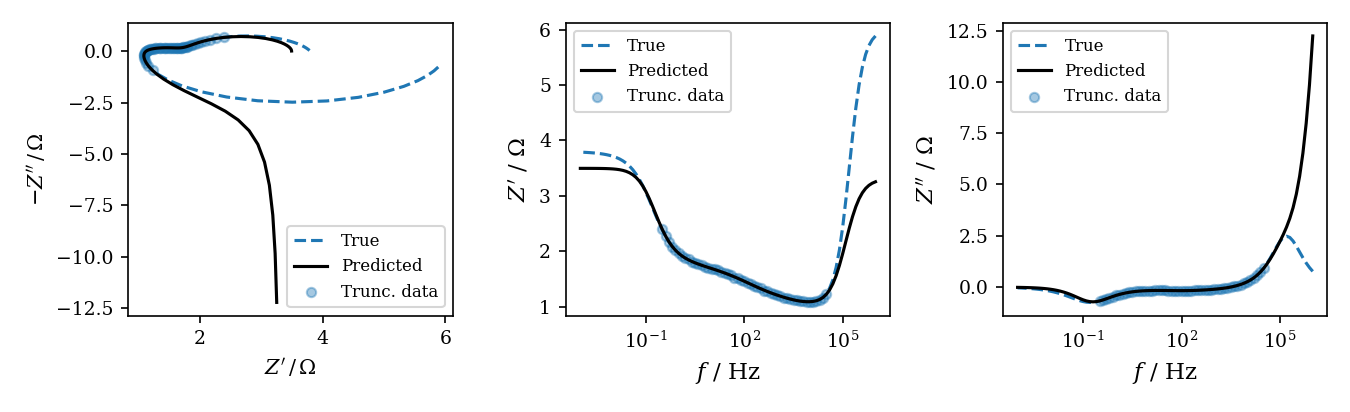

../bayes-drt\drt.py:1079: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


In [12]:
plot_extrap(dr_ridge,Zdf,Zdf_full)

The model extrapolates the low-frequency impedance fairly accurately. However, the extrapolated impedance in the high-frequency region reveals that the model uses a combination of pure inductance and a resistive-inductive DRT feature to fit the impedance response of the RL element, resulting in a large deviation from the true $Z^{\prime\prime}$ at high frequencies. This is difficult to avoid given the small number of measured data points describing the RL element; the model inherently favors using pure inductance and pure (ohmic) resistance to fit the impedance rather than increasing density in the DRT, such that a combination of inductance and moderate negative density in the DRT is more probably than large negative density in the DRT. If there were more data points defining the RL element, the stronger evidence in the data would allow for a larger negative spike in the DRT and a corresponding reduction in the pure inductance. To make clear the effect of the pure inductance, the extrapolated impedance without the effect of the inductance is shown below.

Pure inductance = 1.90e-06 H


<IPython.core.display.Javascript object>


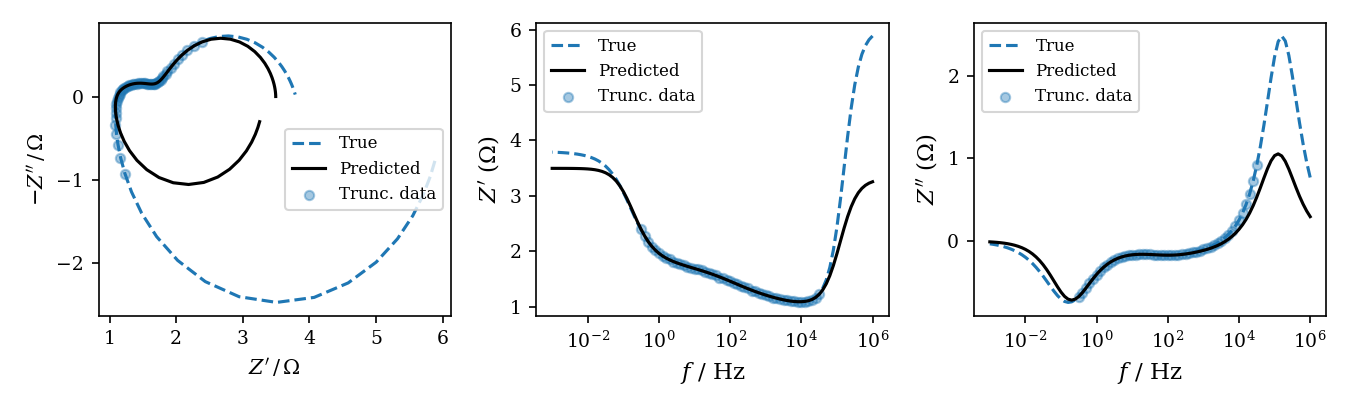

../bayes-drt\drt.py:1078: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


In [48]:
# display the inductance
print('Pure inductance = {:.2e} H'.format(dr_ridge.coef_[1]))
# make a copy of the DRT object and set the inductance to zero
dr_noL = deepcopy(dr_ridge)
dr_noL.coef_[1] = 0
# plot the extrapolated impedance without the pure inductance
plot_extrap(dr_noL,Zdf,Zdf_full)

# Hierarchical Bayesian fit via MCMC sampling

In [33]:
# sample without obtaining initial parameter estimates from the hyperparametric ridge fit
# copy dr_ridge - A matrices already calculated
dr_mcmc = deepcopy(dr_ridge)
start = time.time()
dr_mcmc.bayes_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MCMC sampling time (without initial estimates): {:.2f} s'.format(elapsed))

MCMC sampling time (without initial estimates): 109.92 s


<IPython.core.display.Javascript object>


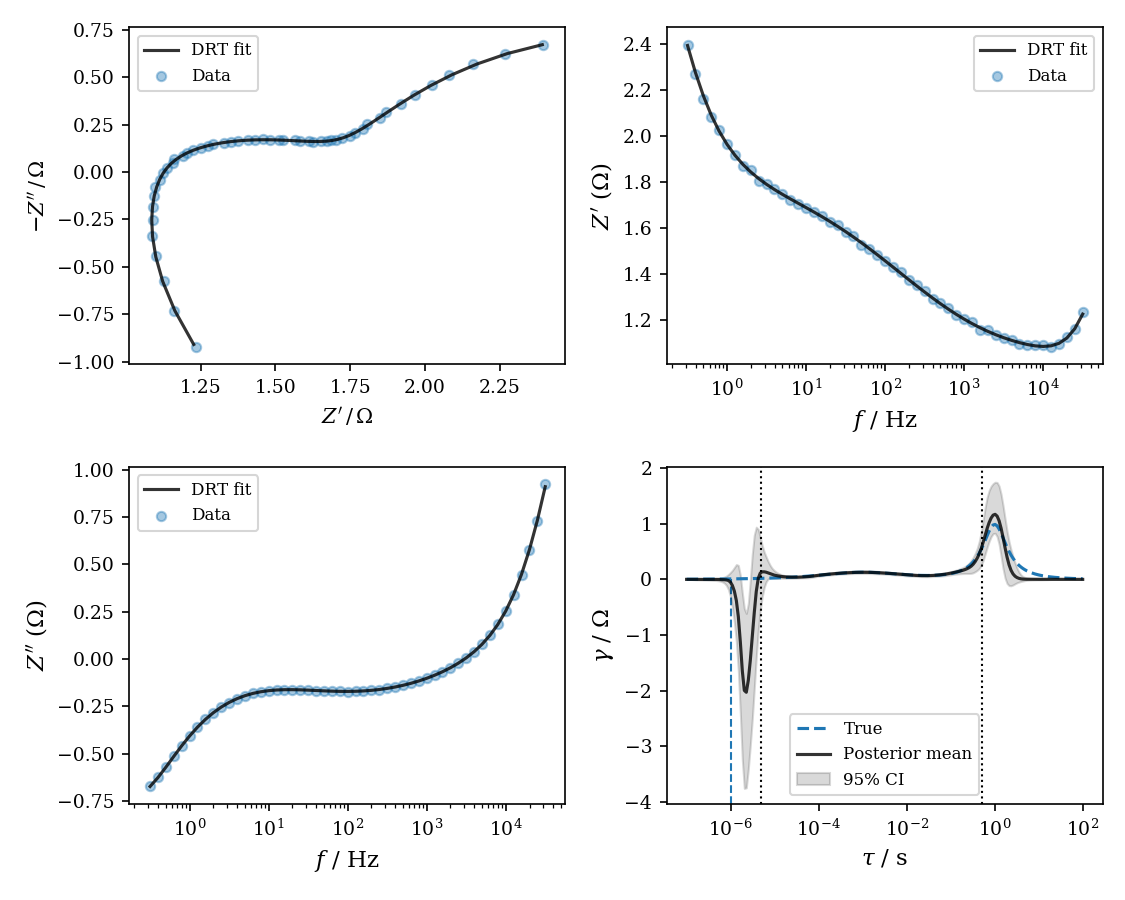

In [53]:
plot_drt_result(dr_mcmc,Zdf,g_true,plot_ci=True)

<IPython.core.display.Javascript object>


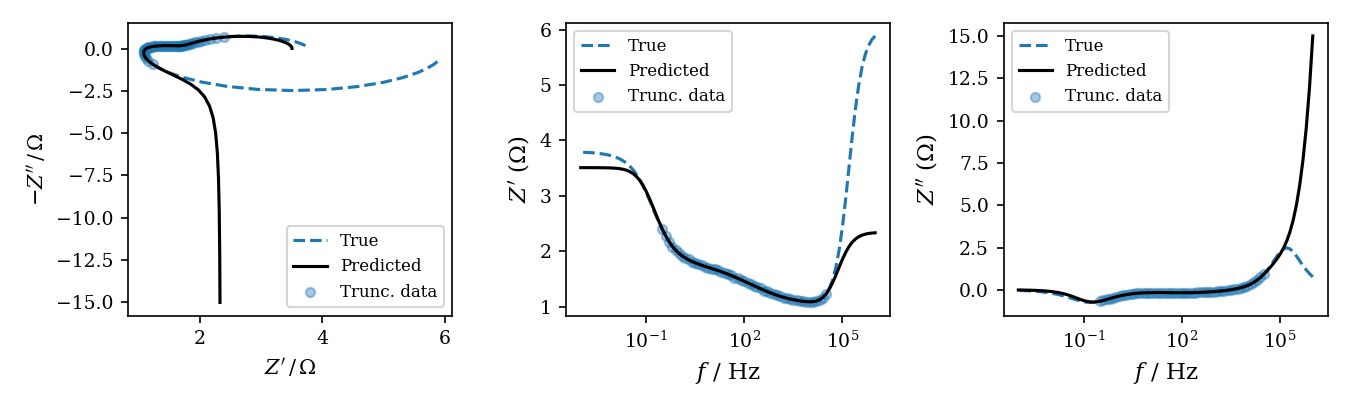

../bayes-drt\drt.py:1078: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


In [49]:
plot_extrap(dr_mcmc,Zdf,Zdf_full)

The MCMC solution is very similar to the hyperparametric ridge solution, but the negative peak in the DRT is smaller and shifted slightly farther to the right. This results in a larger pure inductance contribution, as visible in the plot of the extrapolated impedance. The credibility intervals indicate the large degree of uncertainty in the magnitude and shape of the features in the DRT that lie outside the measured frequency range.

# Hierarchical Bayesian fit via MAP optimization

In [50]:
# run MAP optimization without initial parameter estimates
dr_map = deepcopy(dr_ridge)
start = time.time()
dr_map.map_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MAP optimization time (without initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (without initial estimates): 6.69 s


<IPython.core.display.Javascript object>


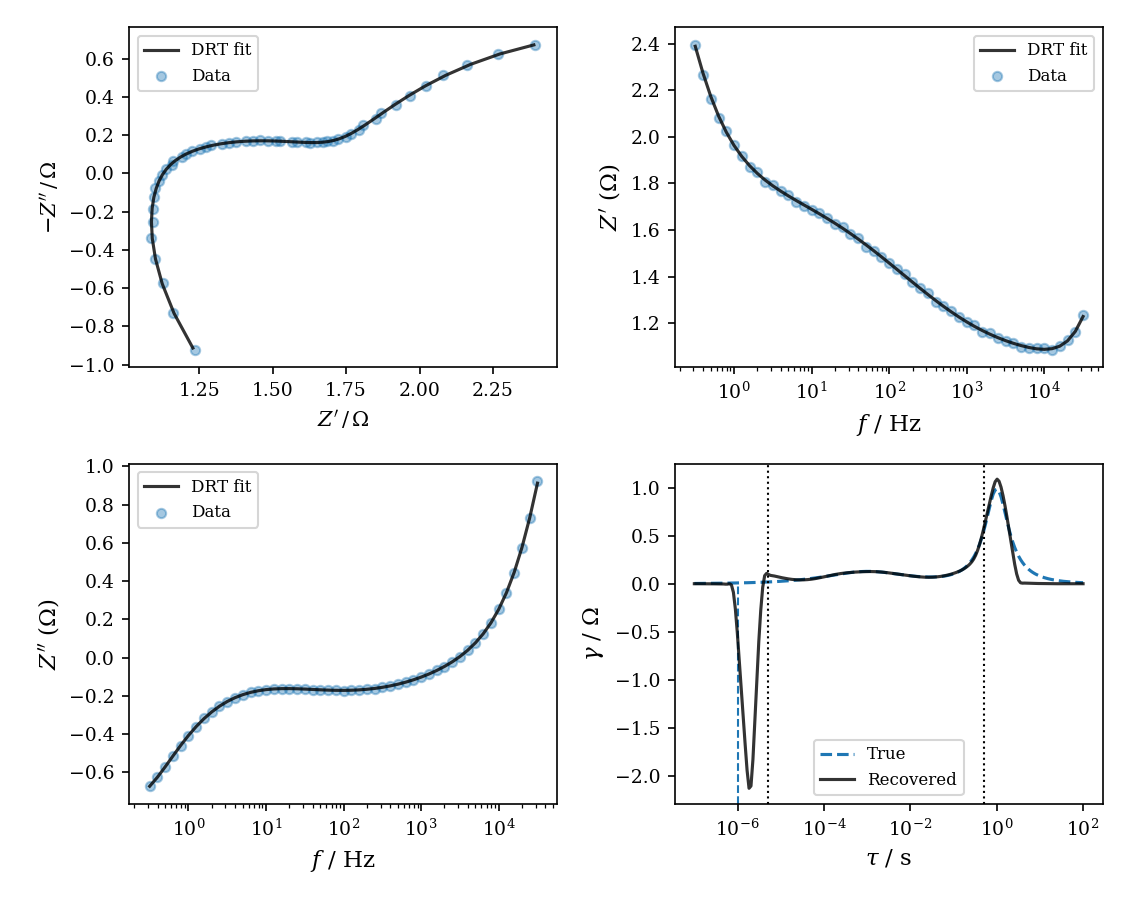

In [52]:
plot_drt_result(dr_map,Zdf,g_true)

<IPython.core.display.Javascript object>


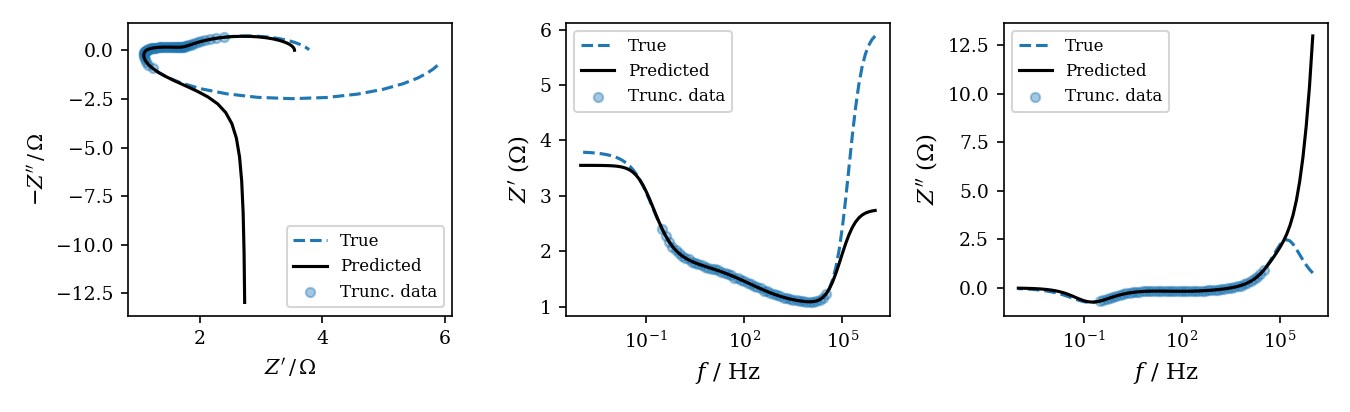

../bayes-drt\drt.py:1078: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


In [54]:
plot_extrap(dr_map,Zdf,Zdf_full)

The MAP solution mirrors the posterior mean obtained via MCMC sampling, but requires an order of magnitude less runtime.